# CNN for TFBS predictions and model interpretability

In this notebook we will how easy it is to train a CNN on DNA data contains binding sites for proteins, make predictions for Transcription Factor Binding Sites (TFBS) and extract the learned motif with a simple gradient-based method.

## Load Necessary Libraries

In [1]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dense, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Load the sequence data

In [3]:
input_fasta_data = pd.read_table("sequences_mod.txt", header=None)
input_fasta_data.rename(columns={0: "sequence"}, inplace=True)
sequence_length = len(input_fasta_data.sequence[0])
print(sequence_length)

50


## Feature extraction and OHE

In [4]:
iec = LabelEncoder()   
ohe = OneHotEncoder(categories='auto')    
seq_matrix = [] 
for sequence in input_fasta_data.sequence: 
  iecd = iec.fit_transform(list(sequence)) 
  iecd = np.array(iecd).reshape(-1, 1) 
  ohed = ohe.fit_transform(iecd)
  seq_matrix.append(ohed.toarray())
seq_matrix = np.stack(seq_matrix)
print(seq_matrix.shape)

(2000, 50, 4)


## Target labels

In [6]:
labels = pd.read_csv('labels.txt')
Y = np.array(labels).reshape(-1) 
print(Y.shape)


(2000,)


### Distribution of Positive and Negative samples

In [7]:
print(pd.DataFrame(Y).value_counts())

0    1013
1     987
dtype: int64


# Train-test split
Before we train the model, let’s split the dataset into training and test datasets so that we can use
training data for model training and test data for model evaluation:

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(seq_matrix, Y, test_size=0.25, random_state=42, shuffle=True) 
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

print(X_train.shape)
print(Y_train.shape)

(1500, 50, 4)
(1500,)


In [9]:
# Reshaping the data so it corresponds to the input format of keras
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_train.shape, X_train_reshaped.shape)
print(X_test.shape, X_test_reshaped.shape)

(1500, 50, 4) (1500, 50, 4, 1)
(500, 50, 4) (500, 50, 4, 1)


## Create a CNN

We start with a fairly simple NN architeture of a single convolutional layer followed by a max-pooling layer
and then a single dense layer.

In [10]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, input_shape=(50, 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 16)                4624      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
______________________________________________________

2022-10-30 16:34:40.447831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Fit the model

In [11]:
history = model.fit(X_train_reshaped, Y_train,
          batch_size=10, epochs=10,
          validation_split=0.1)

Epoch 1/10
135/135 [==============================] - 1s 2ms/step - loss: 0.2129 - val_loss: 0.1548
Epoch 2/10
135/135 [==============================] - 0s 1ms/step - loss: 0.1240 - val_loss: 0.1124
Epoch 3/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0896 - val_loss: 0.0909
Epoch 4/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0696
Epoch 5/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0398 - val_loss: 0.0570
Epoch 6/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0451
Epoch 7/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0177 - val_loss: 0.0630
Epoch 8/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0149 - val_loss: 0.0390
Epoch 9/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0341
Epoch 10/10
135/135 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0339

# Visualization

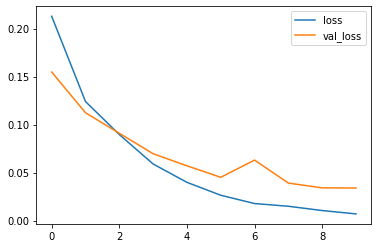

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

## Evaluating the Model

Using metrics such as AUC and AUPRC

In [13]:
# Model predictions
pred = model.predict(X_test_reshaped, batch_size=32).flatten()

16/16 [==============================] - 0s 955us/step


In [14]:
# Model metrics such as AUC to get an estimate how good the NN actually learned
fpr, tpr, thresholds = roc_curve(Y_test, pred)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, pred))

AUC 0.9971483042022461
AUPRC 0.9969029074117326


## Make a saliency plot:

In [15]:
# Plot the motif for the sequences
plot_ids = np.random.randint(0, len(X_test), 1)

# Get the Y ~ X for the sequences we want to plot
seq_matrix_plot = seq_matrix.reshape((seq_matrix.shape[0], seq_matrix.shape[1], seq_matrix.shape[2], 1))[plot_ids, :]
seq_matrix_plot_pred = model.predict(seq_matrix_plot, batch_size=32).flatten()

1/1 [==============================] - 0s 17ms/step


## Calculate Gradient

In [16]:
# Generate a new set of X where for each sequence every nucleotide is consecutively set to 0
X = np.repeat(seq_matrix_plot, 50, axis=0)

first = np.ones((50, 50), int)
np.fill_diagonal(first, 0)
second = np.repeat(first.reshape((1,50,50)), seq_matrix_plot.shape[0], axis=0)
third = np.concatenate(second, axis=0)
fourth = np.multiply(X, np.repeat(third.reshape((X.shape[0], 50, 1, 1)), 4, axis=2))

print(seq_matrix_plot.shape)
print(fourth.shape)

(1, 50, 4, 1)
(50, 50, 4, 1)


In [17]:
# Calculate the prediction for each sequence with one deleted nucleotide
fourth_pred = model.predict(fourth, batch_size=32).flatten()

# Calculating scores
scores = np.reshape((np.repeat(seq_matrix_plot_pred, 50) - fourth_pred), (len(plot_ids),50))

2/2 [==============================] - 0s 2ms/step


## Make the Motif/Saliency plot
#### I used motif_plotter package available at https://github.com/const-ae/motif_plotter. Make sure you copy the motif_plotter folder from that repo before executing this command

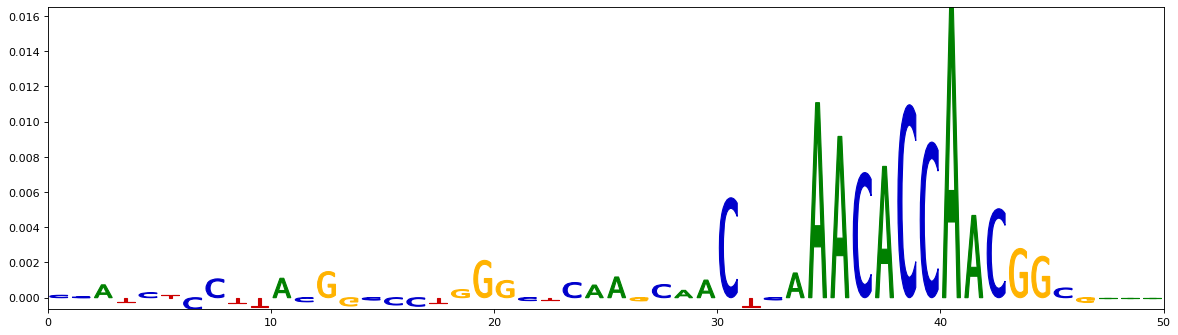

In [24]:
import motif_plotter 
import matplotlib.pyplot as plt

for idx in range(0,len(plot_ids)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, 
                                                seq_matrix_plot[idx].reshape((50, 4)),
                                                np.arcsinh(scores[idx]).reshape(50,1))
    plt.show()
